<a href="https://colab.research.google.com/github/cuongngm/AssignmentCNN/blob/master/map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/map

/content/drive/My Drive/map


In [ ]:
!unzip -q 'train.zip'

In [ ]:
import pandas as pd
train_df = pd.read_csv('new_map.csv')
train_df.head()

,Image,Label
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2108 entries, 0 to 2107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   2108 non-null   object
 1   Label   2108 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [ ]:
train_df.Label.value_counts()

1    1078
0    1030
Name: Label, dtype: int64

In [ ]:
map_dict = {0: 'no_map', 1: 'map'}

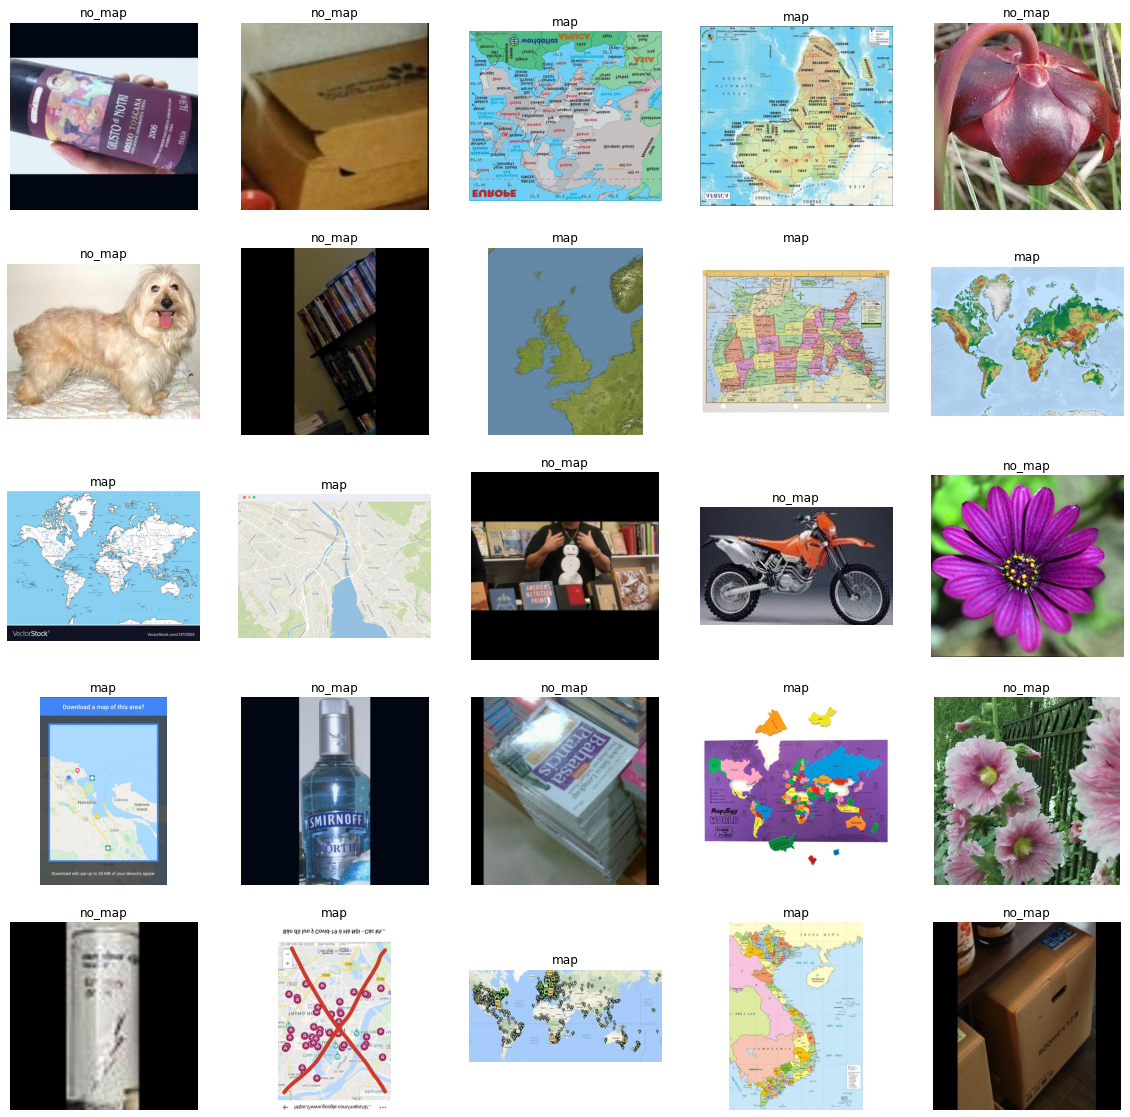

In [ ]:
# visualize
import cv2
import matplotlib.pyplot as plt
import os

def show_image(df, n=5, shuffle=True):
  plt.subplots(figsize=(20,20))
  if shuffle:
    df = df.sample(frac=1).reset_index(drop=True)
  k=1
  for i in range(n*n):
    im = cv2.imread(os.path.join("train",df.loc[k,"Image"]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    label = df.loc[k,"Label"]
    plt.subplot(n,n,k)
    plt.imshow(im)
    plt.title(map_dict[label])
    plt.axis("off")
    k += 1

show_image(train_df)

In [ ]:
# image to array
from PIL import Image
import numpy as np
from tqdm import tqdm
train_files = [os.path.join("train",file) for file in train_df.Image]

def generate_data(image_paths, size=224):
  image_array = np.zeros((len(image_paths), size, size, 3), dtype='uint8')
  for idx, image_path in tqdm(enumerate(image_paths)):
      img = Image.open(image_path).convert("RGB")
      img = img.resize((size,size))
      image_array[idx] = np.array(img).astype('uint8')
  return image_array


In [ ]:
train_arr = generate_data(train_files)

2108it [14:51,  2.37it/s]


In [ ]:
train_y = train_df.Label
train_y.shape

(2108,)

In [ ]:
# one hot encoding
num_classes = 2
import tensorflow as tf
y_ohe = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)

In [ ]:
# suffle data
from sklearn.utils import shuffle
l = y_ohe.shape[0]
shuffle_ = list(range(l))
shuffle_ = shuffle(shuffle_)
# train_arr2,y_ohe = shuffle(train_arr2,y_ohe)
train_arr = train_arr[shuffle_]
y_ohe = y_ohe[shuffle_]


In [ ]:
# train, valid, test
train_x = train_arr[0:1600]
train_y = y_ohe[0:1600]
valid_x = train_arr[1600:1900]
valid_y = y_ohe[1600:1900]
test_x = train_arr[1900:]
test_y = y_ohe[1900:]

In [ ]:
train_x = train_x/255.
valid_x = valid_x/255.
test_x = test_x/255.

In [ ]:
# transfer learning
from keras.applications import VGG16
# Load model VGG16 of ImageNet dataset
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

print("Number of layer in baseModel: ", len(baseModel.layers))
baseModel.summary()

58892288/58889256 [==============================] - 3s 0us/step
Number of layer in baseModel:  19
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________

In [ ]:
# create model
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import UpSampling2D, GlobalAveragePooling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()

model.add(baseModel)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 5

In [ ]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

In [ ]:
baseModel.trainable = False
from keras.callbacks import ModelCheckpoint
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy',
                  metrics=['accuracy'])
mcp = ModelCheckpoint("my_model.h5", monitor="val_accuracy",
                      save_best_only=True, save_weights_only=True)
print('start training')
model.fit_generator(aug.flow(train_x,train_y, batch_size=64), 
                      validation_data=(valid_x,valid_y), epochs=10, steps_per_epoch=train_x.shape[0]//64,verbose=1,callbacks=[mcp])

#unfreeze basemodel
baseModel.trainable = True
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])
model.fit_generator(aug.flow(train_x,train_y, batch_size=64), 
                      validation_data=(valid_x,valid_y), epochs=20, steps_per_epoch=train_x.shape[0]//64,verbose=1,callbacks=[mcp])


start training
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
25/25 [==============================] - 28s 1s/step - loss: 0.3709 - accuracy: 0.8625 - val_loss: 0.2613 - val_accuracy: 0.8800
Epoch 2/10
25/25 [==============================] - 24s 946ms/step - loss: 0.2004 - accuracy: 0.9212 - val_loss: 0.1469 - val_accuracy: 0.9433
Epoch 3/10
25/25 [==============================] - 24s 949ms/step - loss: 0.1605 - accuracy: 0.9381 - val_loss: 0.1008 - val_accuracy: 0.9600
Epoch 4/10
25/25 [==============================] - 23s 920ms/step - loss: 0.1608 - accuracy: 0.9362 - val_loss: 0.1693 - val_accuracy: 0.9433
Epoch 5/10
25/25 [==============================] - 23s 920ms/step - loss: 0.1459 - accuracy: 0.9400 - val_loss: 0.1088 - val_accuracy: 0.9600
Epoch 6/10
25/25 [==============================] - 23s 911ms/step - loss: 0.1463 - accuracy: 0.9344 - val_loss: 0.1045 - val_accuracy: 0.9600
Epoch 7/10
25/25 [==============================] - 24

In [ ]:
model.load_weights('my_model.h5')

In [ ]:
score = model.evaluate(test_x, test_y, verbose=0)
print(score)  

[0.10830462723970413, 0.9519230723381042]


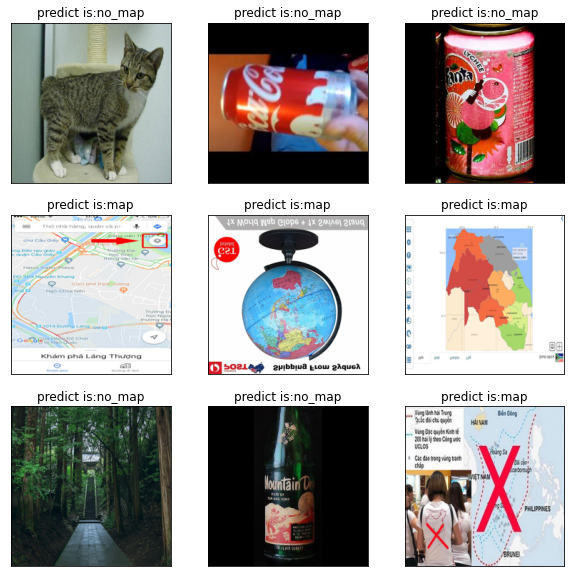

In [ ]:
def visualize_predict_images(X_test,n):
  plt.figure(figsize=(10,10))
  for ind,img in enumerate(X_test[n:n+9]):
    plt.subplot(3,3,ind+1)
    plt.imshow(img)
    plt.title('predict is:{}'.format(map_dict[np.argmax(model.predict(img.reshape(1,224,224,3)))]))
    plt.xticks([])
    plt.yticks([])
  plt.show()
visualize_predict_images(test_x,10)

In [ ]:
from sklearn.metrics import classification_report
labelNames=['no_map', 'map']
pred=model.predict(test_x)
labelFinish=np.argmax(test_y,axis=1)

print(classification_report(labelFinish,np.argmax(pred,axis=1),target_names=labelNames))

              precision    recall  f1-score   support

      no_map       0.96      0.94      0.95       102
         map       0.94      0.96      0.95       106

    accuracy                           0.95       208
   macro avg       0.95      0.95      0.95       208
weighted avg       0.95      0.95      0.95       208



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(test_y, axis = 1),np.argmax(pred, axis = 1))
print(cm)

[[ 96   6]
 [  4 102]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


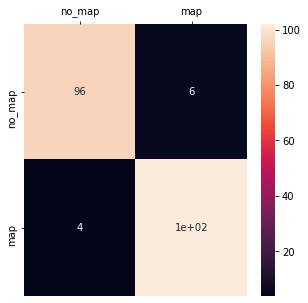

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
df_cm = pd.DataFrame(cm, index = [i for i in labelNames],
                  columns = [i for i in labelNames])

fig, ax = plt.subplots()
ax.xaxis.tick_top()
fig.set_size_inches((5,5))
sn.heatmap(df_cm,annot=True,ax=ax)

In [ ]:
model.save('map_weight.h5')


Saving suburban-house-royalty-free-image-1584972559.jpg to suburban-house-royalty-free-image-1584972559 (1).jpg
[[0.9936173  0.00638271]]
Image is:  no_map


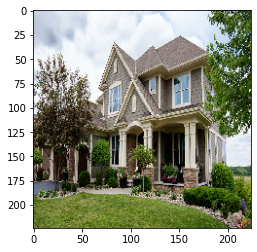

In [ ]:
# predict new image
from google.colab import files
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded=files.upload()
for fn in uploaded.keys():
  path='./'+fn
  img=image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  x=image.img_to_array(img)/255
  x=np.expand_dims(x,axis=0)
  images=np.vstack([x])
  classes=model.predict(images)
  print(classes)
  z=np.argmax(classes)
  label=['no_map','map']
  print('Image is: ',label[z])
